# Segmenting and Clustering Neighborhoods in Toronto

In [2]:
#import libraries
import pandas as pd
import numpy as np
import json #library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim #convert an address into latitude and longitude values

import requests #library to handle requests
from pandas.io.json import json_normalize #tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium  # map rendering library

     |████████████████████████████████| 102kB 9.9MB/s eta 0:00:01


In [3]:
#Read the wikipedia page and extract the tables in that page to form a dataframe
df=pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

#The table we need is the first one in the dataframe
toronto=df[0]

toronto.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
#Replacing the "Not assigned" values in "Borough" column with NaN
toronto['Borough'].replace("Not assigned", np.nan, inplace=True)

toronto.head()

,Postal Code,Borough,Neighbourhood
0,M1A,NaN,Not assigned
1,M2A,NaN,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
#Dropping the rows with NaN values in "Borough" column
toronto.dropna(subset=['Borough'], axis=0, inplace=True)

#Resetting the index
toronto.reset_index(drop=True, inplace=True)

toronto.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
#Determining the no. of rows and columns in our dataframe
toronto.shape

(103, 3)

In [7]:
#Reading the latitude and longitude of Toronto neighborhoods in a dataframe
postal_codes=pd.read_csv("http://cocl.us/Geospatial_data")

postal_codes.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
#Merging the dataframe of neighborhoods with latitude and longitude dataframe with "Postal code" as the key
t_pc=pd.merge(toronto,postal_codes, on='Postal Code')

t_pc.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [9]:
#Getting unique Boroughs
t_pc["Borough"].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [10]:
#Getting coordinates of Toronto using Geocoders
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="Rishika")
loc = geolocator.geocode(address)
lat = loc.latitude
long = loc.longitude

print('The geograpical coordinates of Toronto are {}, {}.'.format(lat, long))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


In [11]:
#Creating map of Toronto showing the boroughs and neighborhoods as per our dataset
toronto_map=folium.Map(location=[lat,long],zoom_start=12)

#marking and labelling
for pc, lat, long, brh, neigh in zip(t_pc['Postal Code'],t_pc['Latitude'], t_pc['Longitude'], t_pc['Borough'], t_pc['Neighbourhood']):
    label = '{}, [{}], {}'.format(pc, neigh, brh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False
    ).add_to(toronto_map)  
    
toronto_map


In [12]:
#using only that neighbourhoods which contain the word "toronto" for clustering of neighborhoods
ct=t_pc[t_pc["Borough"].astype(str).str.contains("Toronto")].reset_index(drop=True)

ct.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


In [89]:
# The code was removed by Watson Studio for sharing.

In [14]:
#defining a function to get categories of venues of all the neighbourhoods considered in "ct" dataset

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'N_Latitude', 
                  'N_Longitude', 
                  'Venue', 
                  'V_Latitude', 
                  'V_Longitude', 
                  'Category']
    
    return(nearby_venues)

In [15]:
ct_venues = getNearbyVenues(
                                   names=ct['Neighbourhood'],
                                   latitudes=ct['Latitude'],
                                   longitudes=ct['Longitude']
                                  )

ct_venues.head()

,Neighbourhood,N_Latitude,N_Longitude,Venue,V_Latitude,V_Longitude,Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [16]:
#checking how many venues we get for each neigghbourhood

ct_venues.groupby('Neighbourhood').count()

,N_Latitude,N_Longitude,Venue,V_Latitude,V_Longitude,Category
Neighbourhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,69,69,69,69,69,69
Christie,18,18,18,18,18,18
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,31,31,31,31,31,31


In [17]:
#checking how many neighbourhoods we have for different categories
ct_venues.groupby('Category').count()

,Neighbourhood,N_Latitude,N_Longitude,Venue,V_Latitude,V_Longitude
Category,,,,,,
Afghan Restaurant,1,1,1,1,1,1
Airport,1,1,1,1,1,1
Airport Food Court,1,1,1,1,1,1
Airport Lounge,2,2,2,2,2,2
Airport Service,3,3,3,3,3,3
Airport Terminal,2,2,2,2,2,2
American Restaurant,22,22,22,22,22,22
Antique Shop,3,3,3,3,3,3
Aquarium,5,5,5,5,5,5


In [18]:
# one hot encoding
ct_onehot = pd.get_dummies(ct_venues[['Category']], prefix="", prefix_sep="")

# adding neighborhood column to the first column
ct_onehot.insert(0, 'Neighbourhood', ct_venues['Neighbourhood'])

ct_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#getting the frequencies of all the venues corresponding to a neighbourhood
ct_frq=ct_onehot.groupby('Neighbourhood').mean().reset_index()

ct_frq.head(10)

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.017857,0.0,0.000000,0.000000,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.062500
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.014493,0.0,0.000000,0.014493,0.0,0.014493
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
6,Church and Wellesley,0.012987,0.000000,0.000000,0.000000,0.000000,0.000000,0.012987,0.0,0.0,...,0.012987,0.000000,0.0,0.0,0.000000,0.0,0.012987,0.000000,0.0,0.025974
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.020000,0.0,0.000000,0.010000,0.0,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.032258,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [20]:
#printing top 5 venues for each neighbourhood
for i, neigh in zip(range(ct_frq.shape[0]),ct_frq['Neighbourhood']):
  print("-------"+neigh+"-------")
  temp=ct_frq[ct_frq['Neighbourhood']==neigh].T.reset_index()  
  temp=temp.iloc[1:]
  temp.columns=['Venue', 'freq']
  print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head())
  print('\n')

-------Berczy Park-------
            Venue       freq
0     Coffee Shop  0.0714286
1        Beer Bar  0.0357143
2            Café  0.0357143
3  Farmers Market  0.0357143
4     Cheese Shop  0.0357143


-------Brockton, Parkdale Village, Exhibition Place-------
            Venue       freq
0            Café      0.125
1  Breakfast Spot  0.0833333
2     Coffee Shop  0.0833333
3             Gym  0.0416667
4          Office  0.0416667


-------Business reply mail Processing Centre, South Central Letter Processing Plant Toronto-------
                  Venue    freq
0           Yoga Studio  0.0625
1               Brewery  0.0625
2  Gym / Fitness Center  0.0625
3         Garden Center  0.0625
4                Garden  0.0625


-------CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport-------
              Venue       freq
0   Airport Service   0.176471
1    Airport Lounge   0.117647
2  Airport Terminal   0.117647
3             Plane  0.05

In [23]:
#function that returns top (x) venues in descending order
def topx_venues (neigh, x):
    cat=neigh.iloc[1:]
    cat_desc=cat.sort_values(ascending=False)
    return cat_desc.index.values[0:x]


In [46]:
#storing the top x venues in a dataframe
columns=['Neighbourhood']
top_x=10
rank=['st', 'nd' , 'rd' , 'th']

#defining the columns
for i in np.arange(top_x):
    if i+1<=3:
        columns.append('Top {}{} venue'.format(i+1, rank[i]))
    else:
        columns.append('Top {}{} venue'.format(i+1, rank[3]))

#creating the dataframe
top_venues=pd.DataFrame(columns=columns)
top_venues['Neighbourhood']=ct_frq['Neighbourhood']

for i in np.arange(ct_frq.shape[0]):
    top_venues.iloc[i, 1:]=topx_venues(ct_frq.iloc[i, :], top_x)
    
top_venues.head()

,Neighbourhood,Top 1st venue,Top 2nd venue,Top 3rd venue,Top 4th venue,Top 5th venue,Top 6th venue,Top 7th venue,Top 8th venue,Top 9th venue,Top 10th venue
0,Berczy Park,Coffee Shop,Café,Cheese Shop,Bakery,Cocktail Bar,Beer Bar,Restaurant,Farmers Market,Seafood Restaurant,Park
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Gym,Pet Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Office
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Garden,Skate Park,Light Rail Station,Burrito Place,Farmers Market,Fast Food Restaurant,Butcher,Restaurant,Auto Workshop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Airport,Airport Food Court,Bar,Harbor / Marina,Boutique,Rental Car Location
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Juice Bar,Bubble Tea Shop,Japanese Restaurant,Thai Restaurant,Department Store,Salad Place


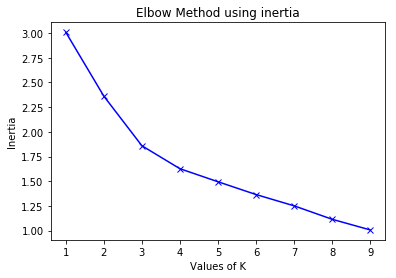

In [63]:
venues_clust=ct_frq.drop('Neighbourhood',1)

#using elbow method to find out the best k

import matplotlib.pyplot as plt
%matplotlib inline

inertia=[]
n=range(1,10)
for k in n:
    kmeans=KMeans(n_clusters=k, random_state=0).fit(venues_clust)
    inertia.append(kmeans.inertia_)

plt.plot(n, inertia, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('Elbow Method using inertia') 
plt.show()

In [64]:
# so the best value of k is 3

In [69]:
#clustering the neighbourhoods using KMeans

kmeans=KMeans(n_clusters=3, random_state=5).fit(venues_clust)
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [73]:
#adding cluster labels to neighbourhoods

top_venues.insert(0, "Cluster labels", kmeans.labels_)

ct_clusters=ct

ct_clusters=ct_clusters.join(top_venues.set_index('Neighbourhood'), on='Neighbourhood')

ct_clusters.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster labels,Top 1st venue,Top 2nd venue,Top 3rd venue,Top 4th venue,Top 5th venue,Top 6th venue,Top 7th venue,Top 8th venue,Top 9th venue,Top 10th venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Café,Park,Breakfast Spot,Pub,Theater,Yoga Studio,Dessert Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Yoga Studio,Diner,Portuguese Restaurant,Persian Restaurant,Park,Mexican Restaurant,Italian Restaurant,Hobby Shop,General Entertainment
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Ramen Restaurant,Bookstore,Pizza Place,Hotel
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,Beer Bar,Restaurant,American Restaurant,Gastropub,Lingerie Store,Department Store,Creperie
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Pub,Coffee Shop,Health Food Store,Trail,Neighborhood,Yoga Studio,Distribution Center,Dim Sum Restaurant,Diner,Discount Store


In [80]:
#visualizing the clusters
toronto_map=folium.Map(location=[lat,long],zoom_start=12)

colors=['red', 'green', 'blue']

for pc, borough, neigh, lat, lng, clust in zip(ct_clusters['Postal Code'], ct_clusters['Borough'], ct_clusters['Neighbourhood'],
                                               ct_clusters['Latitude'], ct_clusters['Longitude'], ct_clusters['Cluster labels']):
                                               label='{},{},[{}],Clust-{}'.format(pc, borough, neigh, clust)
                                               label = folium.Popup(label, parse_html=True)
                                               folium.CircleMarker(
                                               [lat,lng],
                                               radius=5,
                                               popup=label,
                                               color=colors[clust],
                                               fill=True,
                                               fill_color=colors[clust],
                                               fill_opacity=0.7,
                                               parse_html=False).add_to(toronto_map)
                                               
toronto_map


## Examining the clusters---

In [86]:
#Cluster 1
ct_clusters.loc[ct_clusters['Cluster labels']==0, ct_clusters.columns[[0,1,2] + list(range(6, ct_clusters.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Top 1st venue,Top 2nd venue,Top 3rd venue,Top 4th venue,Top 5th venue,Top 6th venue,Top 7th venue,Top 8th venue,Top 9th venue,Top 10th venue
18,M4N,Central Toronto,Lawrence Park,Dim Sum Restaurant,Park,Bus Line,Swim School,Yoga Studio,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
21,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",Park,Trail,Jewelry Store,Sushi Restaurant,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
29,M4T,Central Toronto,"Moore Park, Summerhill East",Park,Trail,Tennis Court,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
33,M4W,Downtown Toronto,Rosedale,Park,Playground,Trail,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [87]:
#Cluster 2
ct_clusters.loc[ct_clusters['Cluster labels']==1, ct_clusters.columns[[0,1,2] + list(range(6, ct_clusters.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Top 1st venue,Top 2nd venue,Top 3rd venue,Top 4th venue,Top 5th venue,Top 6th venue,Top 7th venue,Top 8th venue,Top 9th venue,Top 10th venue
19,M5N,Central Toronto,Roselawn,Health & Beauty Service,Garden,Yoga Studio,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [88]:
#Cluster 3
ct_clusters.loc[ct_clusters['Cluster labels']==2, ct_clusters.columns[[0,1,2] + list(range(6, ct_clusters.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Top 1st venue,Top 2nd venue,Top 3rd venue,Top 4th venue,Top 5th venue,Top 6th venue,Top 7th venue,Top 8th venue,Top 9th venue,Top 10th venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",Coffee Shop,Bakery,Café,Park,Breakfast Spot,Pub,Theater,Yoga Studio,Dessert Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",Coffee Shop,Yoga Studio,Diner,Portuguese Restaurant,Persian Restaurant,Park,Mexican Restaurant,Italian Restaurant,Hobby Shop,General Entertainment
2,M5B,Downtown Toronto,"Garden District, Ryerson",Clothing Store,Coffee Shop,Café,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Ramen Restaurant,Bookstore,Pizza Place,Hotel
3,M5C,Downtown Toronto,St. James Town,Coffee Shop,Café,Cocktail Bar,Beer Bar,Restaurant,American Restaurant,Gastropub,Lingerie Store,Department Store,Creperie
4,M4E,East Toronto,The Beaches,Pub,Coffee Shop,Health Food Store,Trail,Neighborhood,Yoga Studio,Distribution Center,Dim Sum Restaurant,Diner,Discount Store
5,M5E,Downtown Toronto,Berczy Park,Coffee Shop,Café,Cheese Shop,Bakery,Cocktail Bar,Beer Bar,Restaurant,Farmers Market,Seafood Restaurant,Park
6,M5G,Downtown Toronto,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Juice Bar,Bubble Tea Shop,Japanese Restaurant,Thai Restaurant,Department Store,Salad Place
7,M6G,Downtown Toronto,Christie,Grocery Store,Café,Park,Baby Store,Bank,Candy Store,Italian Restaurant,Restaurant,Athletics & Sports,Coffee Shop
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",Coffee Shop,Café,Gym,Clothing Store,Restaurant,Thai Restaurant,Hotel,Bar,Breakfast Spot,Concert Hall
9,M6H,West Toronto,"Dufferin, Dovercourt Village",Pharmacy,Bakery,Brewery,Supermarket,Middle Eastern Restaurant,Café,Music Venue,Bar,Bank,Pet Store
